In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, r2_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score
import itertools
import joblib
import json
import csv

In [2]:
model_info = {
    'model_name': 'Cost Effective Decision Tree (Ingress)',
    'training_file': 'MLM_Decision_Tree_Ingress.ipynb',
    'file_name': '../models/model_dtc_ingress.pkl',
    'scaler_file': '../models/scaler_dtc_ingress.pkl',
    'prepared_by': 'Digital Khalid',
    'library': 'Scikit-Learn',
    'classifier': 'Decision Tree Classifier',
    'normalization': 'Standard Scaler (Z-Score)',
    'data_file': '../datasets/mawi_flows.csv',
    'features': ['src_port', 'dst_port', 'protocol', 'pkt_size_1'],
    'target': ['elephant'],
}

In [3]:
# Read data file
input_file = model_info['data_file']
input_file
flows = pd.read_csv(input_file)

In [4]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [5]:
print(f'features (X)\n{X}')

features (X)
         src_port  dst_port  protocol  pkt_size_1
0            1999     54524         6          66
1           50005      3479        17         183
2           44734       443         6          54
3           43332      3128         6          54
4           61554       443         6          85
...           ...       ...       ...         ...
1518385     48152      3128         6          58
1518386      7528        80         6          58
1518387        80     12256         6          66
1518388     44843      2375         6          54
1518389     50355     43527         6          58

[1518390 rows x 4 columns]


In [6]:
print(f'features (y)\n{y}')

features (y)
         elephant
0               0
1               1
2               0
3               0
4               0
...           ...
1518385         0
1518386         0
1518387         0
1518388         0
1518389         0

[1518390 rows x 1 columns]


In [7]:
# Data Normalization
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_norm = scaler.fit_transform(X)
X_norm

array([[-1.48137583,  2.11086118, -0.33874667, -0.11701203],
       [ 0.75371663, -0.59077602,  2.95205852,  1.07173183],
       [ 0.50830622, -0.75146112, -0.33874667, -0.23893448],
       ...,
       [-1.5707218 , -0.12623944, -0.33874667, -0.11701203],
       [ 0.51338111, -0.64920697, -0.33874667, -0.23893448],
       [ 0.77001214,  1.52882759, -0.33874667, -0.19829367]])

In [8]:
# Percentage of Elephant and Mice Flows
flows['elephant'].value_counts()/ flows.shape[0] * 100

elephant
0    99.887578
1     0.112422
Name: count, dtype: float64

### Cost Effective Decision Tree (Using best hyperparameters)

In [9]:
# Split dataset into test and train set
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [10]:
best_param_grid = {
    'class_weight': {0:1, 1:1200},
    'max_depth': 10,
    'min_samples_split': 3,
    'criterion': 'gini',
    'splitter': 'best',
}

# define model
model = DecisionTreeClassifier(**best_param_grid)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [11]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5122856295673398
Recall: 0.9441602222850063
F1 Score: 0.5134226744516965
Accuracy: 0.9585456193130628
False Positive Rate: 0.04142194418876971
True Positive Rate: 0.9297423887587822
ROC_AUC: 0.9441602222850062


In [8]:
model = joblib.load(model_info['file_name'])

In [9]:
scaler = joblib.load(model_info['scaler_file'])

In [10]:
model.feature_importances_

array([0.14113713, 0.1980224 , 0.02870343, 0.63213703])

In [11]:
features = model_info['features']
target = model_info['target']

X = flows[features]
y = flows[target]

In [141]:
X_norm = scaler.transform(X)

In [142]:
predictions = model.predict(X_norm)

In [143]:
predictions

array([0, 1, 0, ..., 0, 0, 0])

In [144]:
predictions = pd.Series(predictions, index=X.index)
predictions

0          0
1          1
2          0
3          0
4          1
          ..
1518385    0
1518386    0
1518387    0
1518388    0
1518389    0
Length: 1518390, dtype: int64

In [145]:
pred_flows = pd.concat([flows, predictions], axis=1)
pred_flows

,start_time,end_time,src_ip,dst_ip,protocol,src_port,dst_port,pkt_size_1,pkt_size_2,pkt_size_3,...,7_pkt_max_iat,7_pkt_mean_iat,7_pkt_duration,flow_size,flow_pkt_count,flow_max_iat,flow_mean_iat,flow_duration,elephant,0
0,1688187600,1688187685,149.40.55.233,203.115.138.41,6,1999,54524,66,66,66,...,19,12.4375,44,792,12,19,6.982422e+00,85,0,0
1,1688187600,1688187692,202.11.248.134,52.113.75.222,17,50005,3479,183,191,196,...,0,0.0000,0,841789,4697,1,4.547474e-13,92,1,1
2,1688187600,1688187606,45.100.248.16,202.249.92.162,6,44734,443,54,54,54,...,4,2.5000,6,216,4,4,2.500000e+00,6,0,0
3,1688187600,1688187600,38.88.114.91,163.37.23.124,6,43332,3128,54,0,0,...,0,0.0000,0,54,1,0,0.000000e+00,0,0,0
4,1688187600,1688187600,163.37.117.124,38.186.128.63,6,61554,443,85,54,0,...,0,0.0000,0,139,2,0,0.000000e+00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518385,1688187692,1688187692,45.197.187.47,163.37.128.119,6,48152,3128,58,0,0,...,0,0.0000,0,58,1,0,0.000000e+00,0,0,0
1518386,1688187692,1688187692,167.248.189.103,163.37.93.253,6,7528,80,58,0,0,...,0,0.0000,0,58,1,0,0.000000e+00,0,0,0
1518387,1688187692,1688187692,202.249.93.185,46.25.179.131,6,80,12256,66,66,0,...,0,0.0000,0,132,2,0,0.000000e+00,0,0,0
1518388,1688187692,1688187692,146.64.20.95,150.161.104.40,6,44843,2375,54,0,0,...,0,0.0000,0,54,1,0,0.000000e+00,0,0,0


In [126]:
# pred_flows.rename(columns={'elephant': 'actual_elephant'}, inplace=True)

In [146]:
pred_flows.rename(columns={0: 'predicted_elephant'}, inplace=True)

In [147]:
pred_flows

,start_time,end_time,src_ip,dst_ip,protocol,src_port,dst_port,pkt_size_1,pkt_size_2,pkt_size_3,...,7_pkt_max_iat,7_pkt_mean_iat,7_pkt_duration,flow_size,flow_pkt_count,flow_max_iat,flow_mean_iat,flow_duration,elephant,predicted_elephant
0,1688187600,1688187685,149.40.55.233,203.115.138.41,6,1999,54524,66,66,66,...,19,12.4375,44,792,12,19,6.982422e+00,85,0,0
1,1688187600,1688187692,202.11.248.134,52.113.75.222,17,50005,3479,183,191,196,...,0,0.0000,0,841789,4697,1,4.547474e-13,92,1,1
2,1688187600,1688187606,45.100.248.16,202.249.92.162,6,44734,443,54,54,54,...,4,2.5000,6,216,4,4,2.500000e+00,6,0,0
3,1688187600,1688187600,38.88.114.91,163.37.23.124,6,43332,3128,54,0,0,...,0,0.0000,0,54,1,0,0.000000e+00,0,0,0
4,1688187600,1688187600,163.37.117.124,38.186.128.63,6,61554,443,85,54,0,...,0,0.0000,0,139,2,0,0.000000e+00,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518385,1688187692,1688187692,45.197.187.47,163.37.128.119,6,48152,3128,58,0,0,...,0,0.0000,0,58,1,0,0.000000e+00,0,0,0
1518386,1688187692,1688187692,167.248.189.103,163.37.93.253,6,7528,80,58,0,0,...,0,0.0000,0,58,1,0,0.000000e+00,0,0,0
1518387,1688187692,1688187692,202.249.93.185,46.25.179.131,6,80,12256,66,66,0,...,0,0.0000,0,132,2,0,0.000000e+00,0,0,0
1518388,1688187692,1688187692,146.64.20.95,150.161.104.40,6,44843,2375,54,0,0,...,0,0.0000,0,54,1,0,0.000000e+00,0,0,0


In [ ]:
# Save dataset with predictions as a csv file without index
output_file = 'flows_predicted.csv'
pred_flows.to_csv(output_file, index=False)
print('Done')

In [127]:
misclassifications = pred_flows.query('actual_elephant != predicted_elephant')

In [ ]:
# Save misclassified dataset as a csv file without index
output_file = 'flows_misclassified.csv'
misclassifications.to_csv(output_file, index=False)
print('Done')

In [149]:
pred_elephants = pred_flows.query('predicted_elephant==1')

In [150]:
# Save all predicted elephant flows as a csv file without index
output_file = '../datasets/flows_ingress_elephant.csv'
pred_elephants.to_csv(output_file, index=False)
print('Done')

Done


In [133]:
# pd.set_option('display.max_rows', None)
pred[pred['predicted_elephant'] == 1].value_counts()

NameError: name 'pred' is not defined

In [26]:
pred.query('src_port==0 & dst_port==0 & actual_elephant==0 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  flow_size  packet_count  actual_elephant  predicted_elephant
0         0         47        1502            15618      67            0                1                     1
Name: count, dtype: int64

In [59]:
pred.query('protocol==17 & actual_elephant==1 & predicted_elephant==1').value_counts()

src_port  dst_port  protocol  first_pkt_size  flow_size  packet_count  actual_elephant  predicted_elephant
80        57777     17        63              112266     1782          1                1                     2
          39308     17        176             670490     3707          1                1                     1
1194      55802     17        82              1276639    1058          1                1                     1
3214      8801      17        106             372458     2103          1                1                     1
3074      30480     17        170             518189     3379          1                1                     1
                                                                                                             ..
443       56006     17        1292            143546     117           1                1                     1
          55921     17        1392            1400915    1031          1                1                    

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, random_state=1, test_size=0.25, stratify=y)

In [30]:
y_pred = model.predict(X_test)

In [31]:
# Evaluate the model's performance
precision = precision_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Precision:", precision)

recall = recall_score(y_test, y_pred, average = 'macro', zero_division=0)
print("Recall:", recall)

f1 = f1_score(y_test, y_pred, average = 'macro', zero_division=0)
print("F1 Score:", f1)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
print(f'False Positive Rate: {fpr[1]}\nTrue Positive Rate: {tpr[1]}\nROC_AUC: {roc_auc}')

Precision: 0.5024234041552332
Recall: 0.8977760290415926
F1 Score: 0.45221876812560585
Accuracy: 0.8097370966285006
False Positive Rate: 0.19042925032802974
True Positive Rate: 0.985981308411215
ROC_AUC: 0.8977760290415926


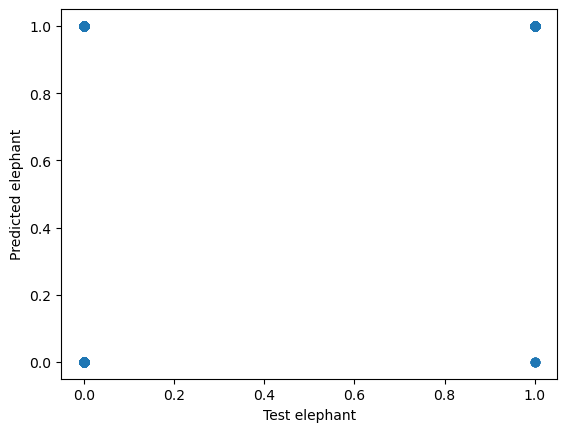

In [32]:
fig, ax = plt.subplots()
ax.set_xlabel('Test ' + target[0])
ax.set_ylabel('Predicted ' + target[0])
ax.scatter(y_test, y_pred)

(array([367118.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  86775.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

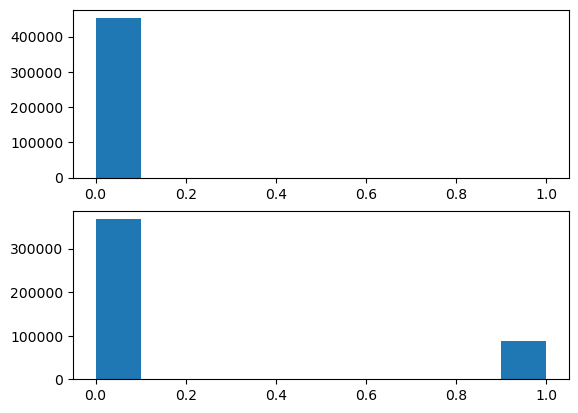

In [33]:
fig, ax = plt.subplots(2)
ax[0].hist(y_test)
ax[1].hist(y_pred)

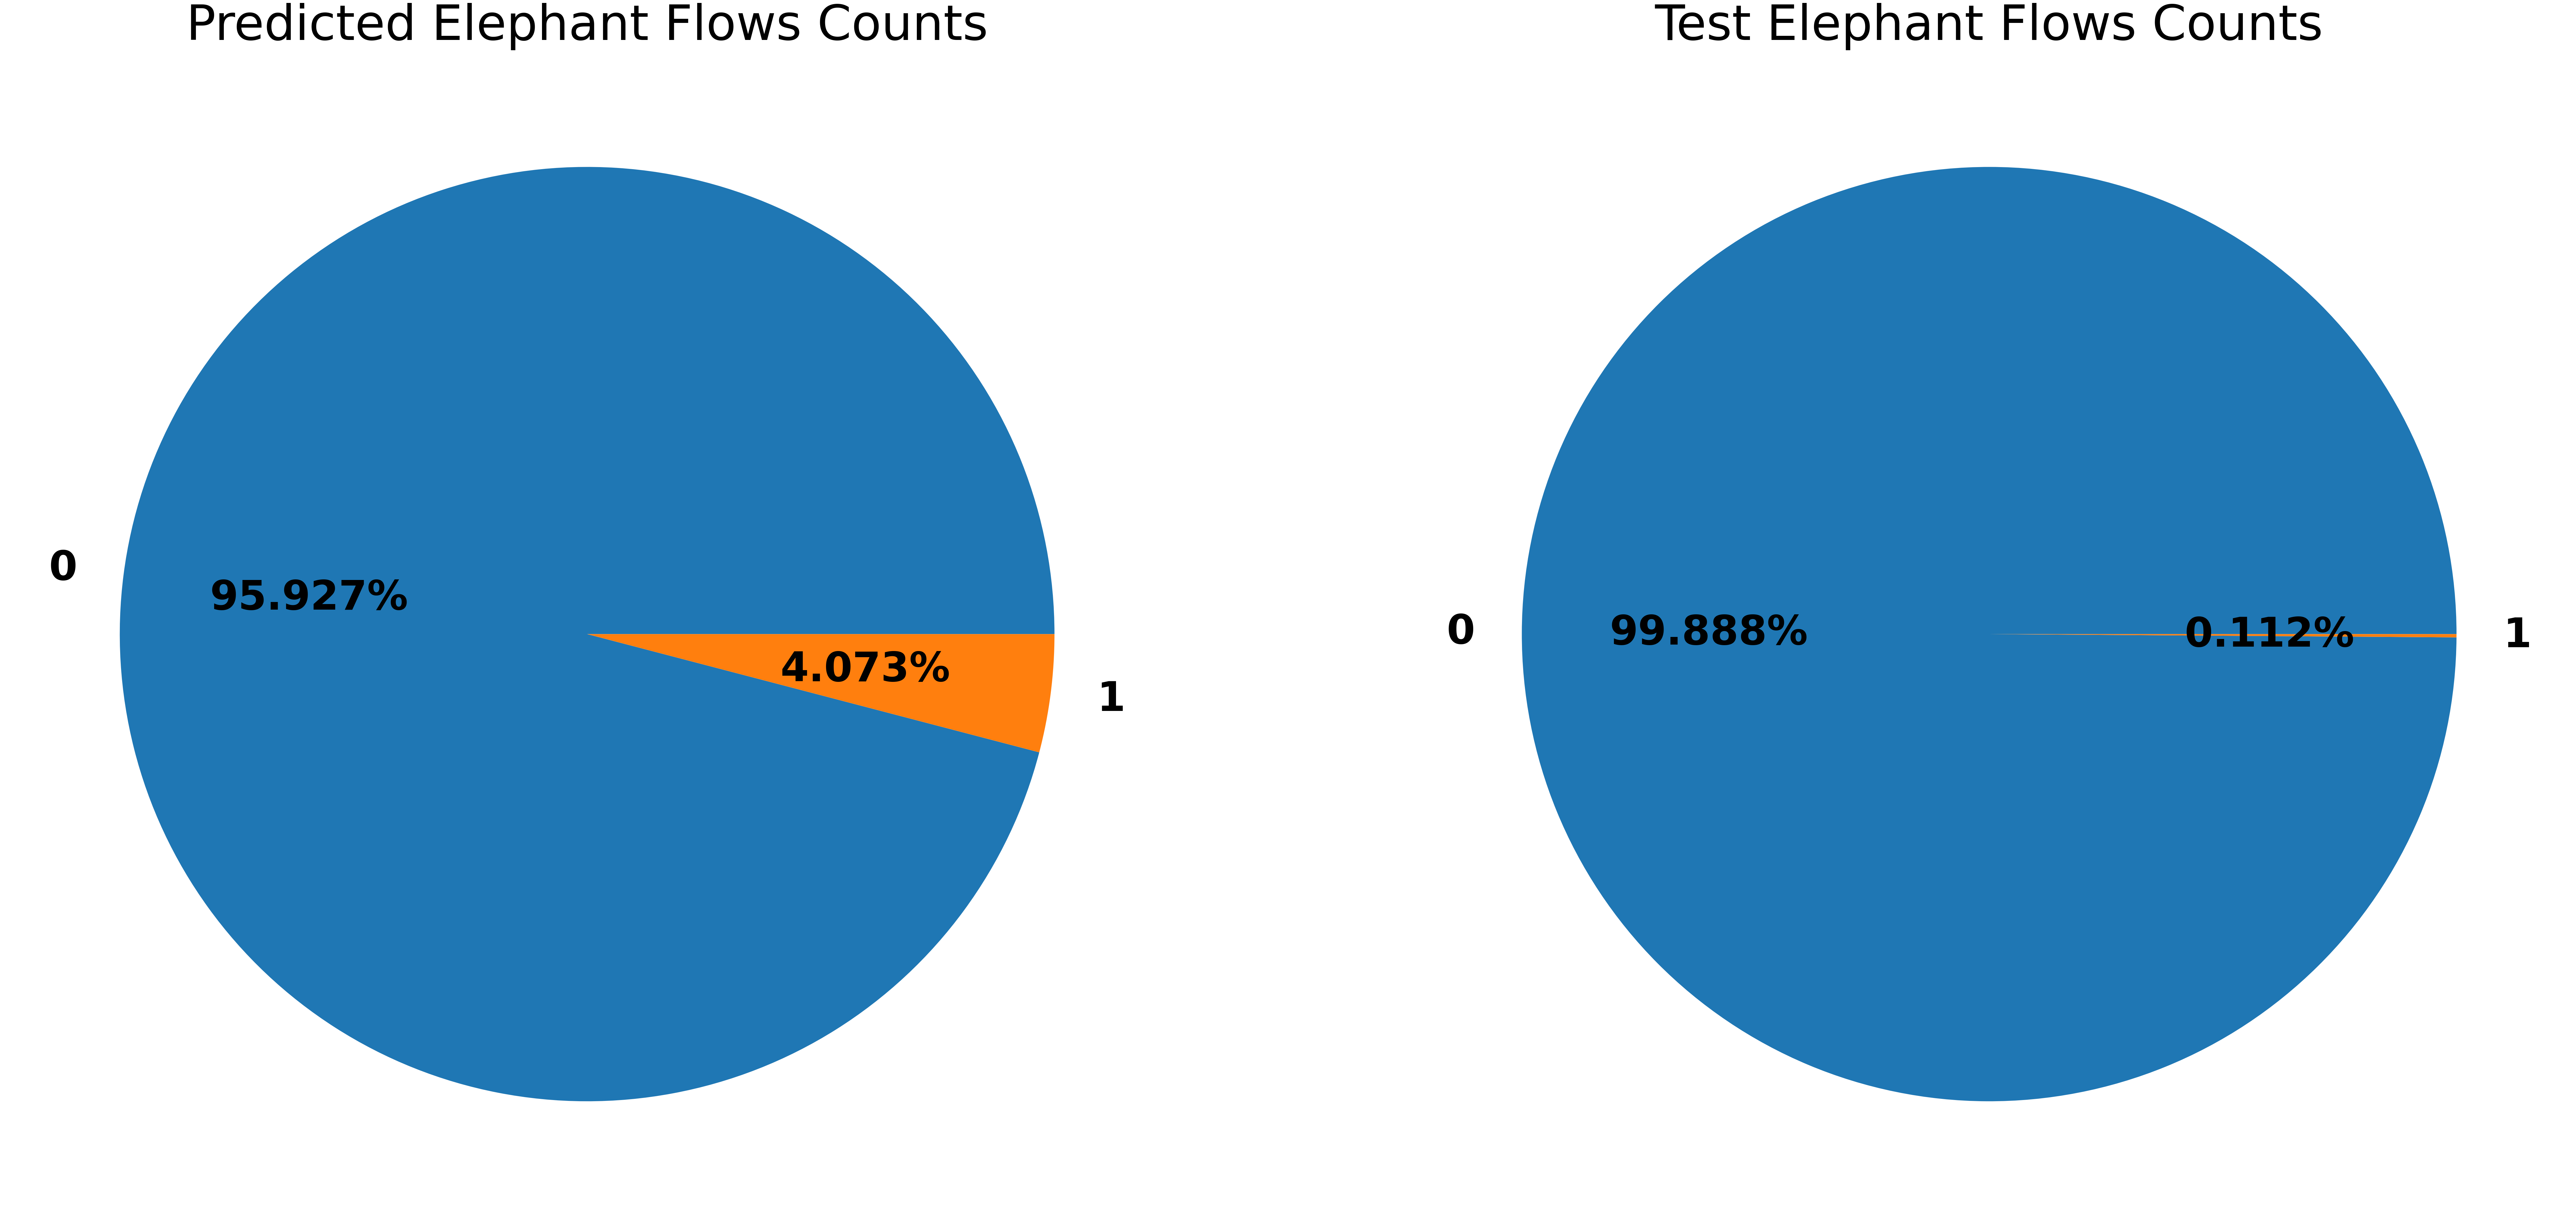

In [53]:
predictions = pd.DataFrame(y_pred)
testset = pd.DataFrame(y_test)

# get the set of distinct classes
labels_pred = predictions[0].unique()
labels_test = testset.elephant.unique()

# get the count of each class
sizes_pred = predictions[0].value_counts().values
sizes_test = testset.elephant.value_counts().values

font = {#'family' : 'normal',
        'weight' : 'bold',
        'size'   : 100}

matplotlib.rc('font', **font)

# plot the class value counts
fig, ax = plt.subplots(1, 2, sharey='row', figsize=(100, 100))
plt.subplots_adjust(bottom=0.1, right=1, top=0.5)

ax[0].pie(sizes_pred, labels=labels_pred, autopct='%1.3f%%')
ax[0].set_title('Predicted Elephant Flows Counts')

ax[1].pie(sizes_test, labels=labels_test, autopct='%1.3f%%')
ax[1].set_title('Test Elephant Flows Counts')

plt.show()

### Confusion Matrix

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, y_pred, labels=[1,0]))

[[   397     30]
 [ 15706 363465]]


Confusion matrix, without normalization
[[   397     30]
 [ 15706 363465]]


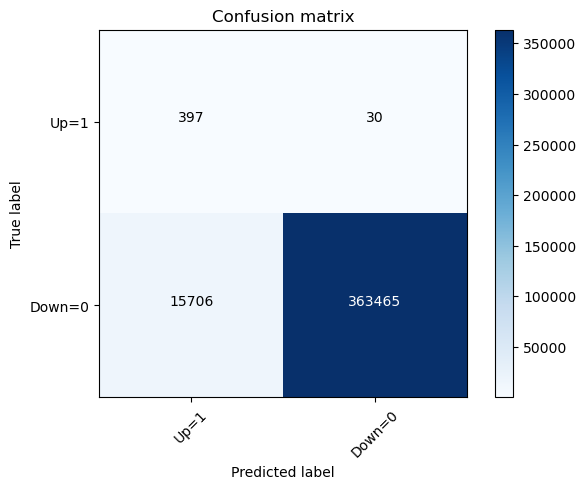

In [13]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Up=1','Down=0'], normalize=False, title='Confusion matrix')


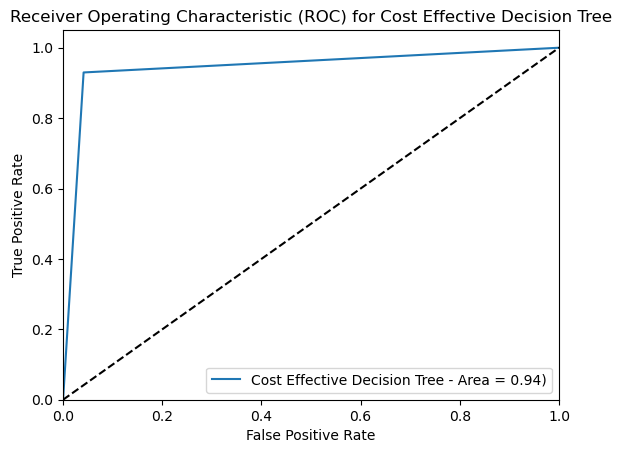

In [14]:
# Plot ROC curve
plt.plot(fpr, tpr, label=f"Cost Effective Decision Tree - Area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic (ROC) for Cost Effective Decision Tree')
plt.legend(loc="lower right")

# Save the ROC curve plot as an image
# plt.savefig(f"ROC_Curve_CEDT.png")

# Show the ROC curve plot
plt.show()